In [1]:

import snntorch as snn
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
# Global params
batch_size = 128
data_path = '../data/mnist'
num_classes = 10

# prepare for the dataset
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])  # 转为tensor，并归一化至[0-1]

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
print(f"The size of mnist_train is {len(mnist_train)}")
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)


The size of mnist_train is 60000


In [3]:
# generate spike information
num_steps = 10
raw_vector = torch.ones(num_steps) * 0.5
rate_code_vector = torch.bernoulli(raw_vector)
print(raw_vector)
print(rate_code_vector)
print(f"The output is spiking {raw_vector.sum()*100/len(rate_code_vector):.2f}% of the time.")


tensor([0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000,
        0.5000])
tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 0.])
The output is spiking 50.00% of the time.


In [9]:
from snntorch import spikegen
# Iterate through minibatches
data = iter(train_loader)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)
print(spike_data.shape)
print(data_it.shape)
print(targets_it)

torch.Size([10, 128, 1, 28, 28])
torch.Size([128, 1, 28, 28])
tensor([9, 8, 5, 4, 0, 3, 9, 8, 0, 2, 4, 3, 8, 1, 7, 0, 7, 4, 6, 6, 2, 5, 6, 6,
        8, 4, 3, 7, 6, 4, 7, 8, 6, 5, 1, 0, 0, 8, 6, 9, 0, 0, 1, 5, 4, 2, 3, 9,
        0, 7, 6, 1, 6, 8, 2, 6, 4, 5, 4, 1, 7, 7, 2, 1, 1, 0, 9, 8, 3, 6, 2, 9,
        8, 3, 1, 9, 1, 4, 6, 7, 9, 6, 6, 0, 0, 1, 3, 4, 7, 9, 3, 3, 1, 4, 6, 3,
        4, 9, 7, 9, 1, 3, 0, 6, 6, 9, 2, 4, 6, 8, 2, 6, 2, 3, 8, 9, 0, 2, 6, 9,
        3, 8, 5, 1, 3, 8, 0, 0])


torch.Size([10, 28, 28])
The corresponding target is: 9


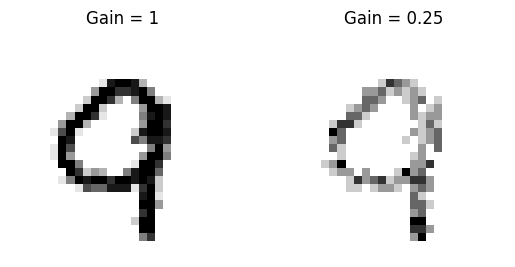

In [16]:
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

spike_data_sample = spike_data[:, 0, 0]

print(spike_data_sample.size())

# `spikeplot.animator` makes it super simple to animate 2-D data.<br>
# Note: if you are running the notebook locally on your desktop, please uncomment the line below and modify the path to your ffmpeg.exe
print(f"The corresponding target is: {targets_it[0]}")

spike_data = spikegen.rate(data_it, num_steps=num_steps, gain=0.25)
spike_data_sample2 = spike_data[:, 0, 0]

plt.figure(facecolor="w")
plt.subplot(1,2,1)
plt.imshow(spike_data_sample.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 1')

plt.subplot(1,2,2)
plt.imshow(spike_data_sample2.mean(axis=0).reshape((28,-1)).cpu(), cmap='binary')
plt.axis('off')
plt.title('Gain = 0.25')

plt.show()


torch.Size([10, 784])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


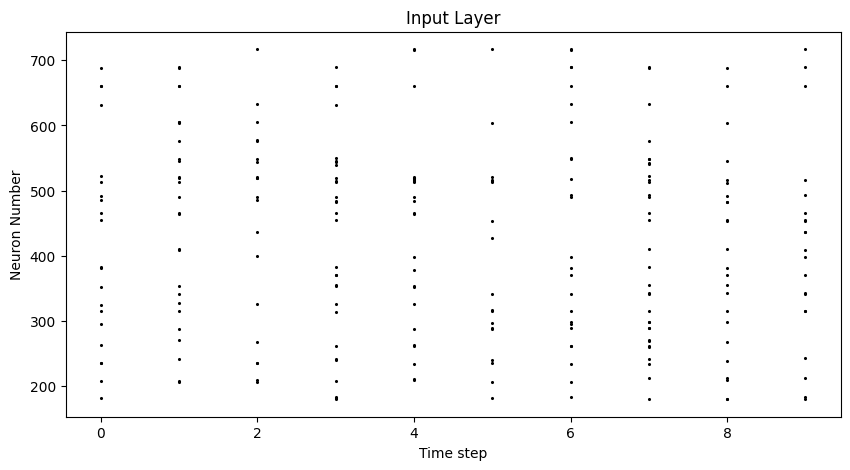

tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]])


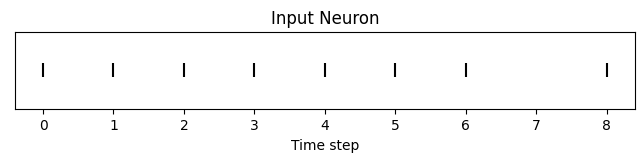

In [21]:
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))
print(spike_data_sample2.shape)
print(spike_data_sample2)
# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

idx = 210  # index into 210th neuron

fig = plt.figure(facecolor="w", figsize=(8, 1))
ax = fig.add_subplot(111)

splt.raster(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1), ax, s=100, c="black", marker="|")
print(spike_data_sample.reshape(num_steps, -1)[:, idx].unsqueeze(1))
plt.title("Input Neuron")
plt.xlabel("Time step")
plt.yticks([])
plt.show()

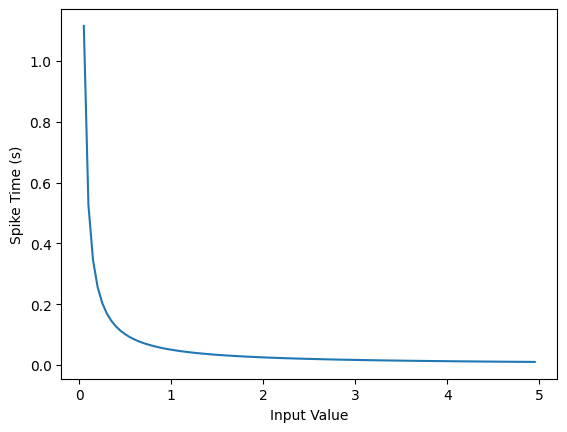

In [22]:
def convert_to_time(data, tau=5, threshold=0.01):
  spike_time = tau * torch.log(data / (data - threshold))
  return spike_time


raw_input = torch.arange(0, 5, 0.05) # tensor from 0 to 5
spike_times = convert_to_time(raw_input)

plt.plot(raw_input, spike_times)
plt.xlabel('Input Value')
plt.ylabel('Spike Time (s)')
plt.show()


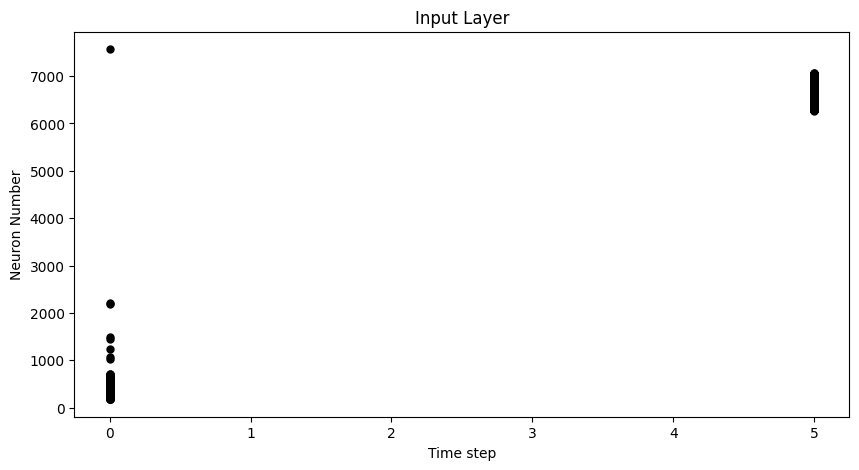

In [24]:
spike_data = spikegen.latency(data_it, num_steps=100, tau=5, threshold=0.01)
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data[:, 0].reshape(num_steps, -1), ax, s=25, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()
